### Fit linear regression and logistic regression to find important words

- Fit classifier to find words that contribute to either treatment effect (KNN,VT,CTF,CSF) or amt perception (labels)

In [119]:
import pickle, pydot, random, re, ast, time
import pandas as pd
import numpy as np
from scipy.sparse import vstack
from sklearn.externals.six import StringIO 
from IPython.display import display
#from sklearn.datasets import load_iris
from sklearn import tree
from IPython.display import Image
from collections import Counter
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

In [120]:
project_path = '/data/2/zwang/2018_S_WordTreatment/'
amt_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/6_amt/'
dataset_list = ['yp','tw','airbnb']
methods = ['KNN','VT','CTF','CSF']
full_name = {'yp':'Yelp','tw':'Twitter','airbnb':'Airbnb'}
data_file = {}
data_file['yp'] = project_path + 'V2_yelp/5_Select/yp_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['tw'] = project_path + 'V2_twitter/5_Select/tw_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit.pickle'
data_file['airbnb'] = project_path + 'V2_airbnb/5_Select/airbnb_wdpair_sents_4effects_posinters_poscom1_bigramcheck_limit_limitvocab.pickle'
vocab_file = project_path+'V2_airbnb/0_Data/common_wds.csv'

In [3]:
def plot_effect_dist():
    """
    Treatment effect distribution for each method, find gap to serve as threshold for binary classification.
    """
    
    for di in range(len(dataset_list)):
        data_pd = pd.DataFrame(pickle.load(open(data_file[dataset_list[di]],'rb')))
        fig,axes = plt.subplots(1,4,figsize=(15,4),sharex=True,sharey=True)
        
        for mi in range(len(methods)):
            axes[mi].plot(np.sort(data_pd[methods[mi].lower()+'_effect'].values))
            axes[mi].set_title(methods[mi]+'_effect')
            axes[mi].get_xaxis().set_visible(False)
        axes[0].set_ylabel(dataset_list[di])

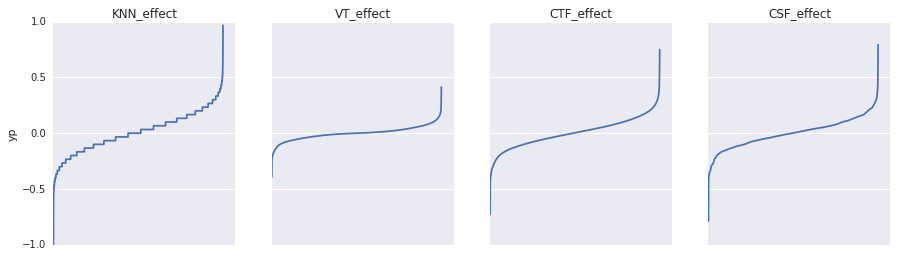

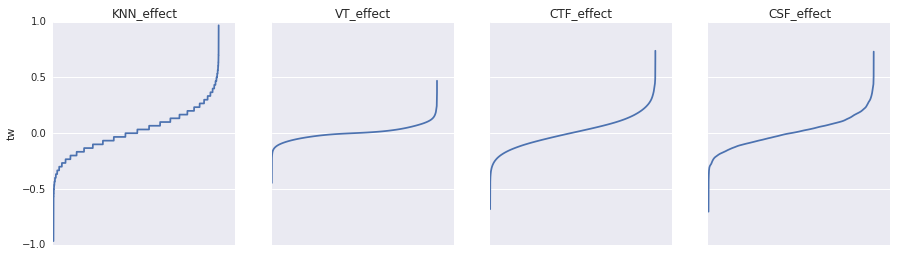

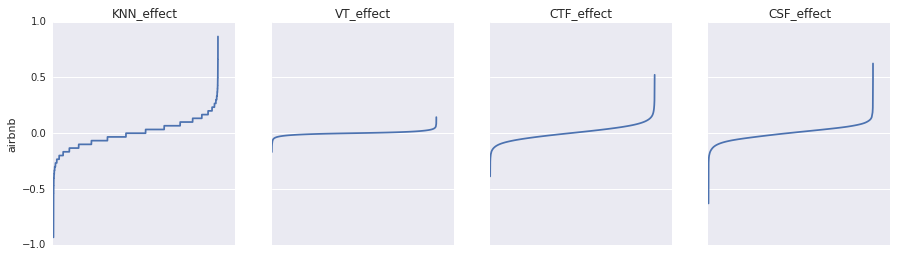

In [24]:
plot_effect_dist()

#### Fit LogisticRegression with treatment effect > 0 and < 0

In [126]:
def fit_binary_LR():
    """
    Fit binary classification model with effect > 0 as pos and effect < 0 as neg.
    """
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        print("Process %s" % (full_name[dataset_list[di]]))
        #data_pd = pd.DataFrame(pickle.load(open(data_file[dataset_list[di]],'rb')))
        data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv')
        # concatenate sentence and target word
        data_pd['sent_tar'] = data_pd['src_sentence'].map(str) + ' '+data_pd['target']
        
#         if(dataset_list[di] == 'airbnb'):
#             my_vocab = list(set(pd.read_csv(vocab_file).word.values))
#             ct_vec = CountVectorizer(min_df=3,max_df=0.9,vocabulary=my_vocab)
#         else:
#             ct_vec = CountVectorizer(min_df=3,max_df=0.9)
            
        ct_vec = CountVectorizer(min_df=3,max_df=0.9)
        X_sents = ct_vec.fit_transform(data_pd.sent_tar.values)
        feats = ct_vec.get_feature_names()
        LR_clf = LogisticRegression(random_state=42,n_jobs=-1)
        
        method_features = []
        for mi in range(len(methods)):
            mth_labels = data_pd[methods[mi].lower()+'_effect'].apply(lambda x: 1 if x>0 else 0)
            print(methods[mi],Counter(mth_labels))
            LR_clf.fit(X_sents,mth_labels)
            top_feats = []
            
            pos_feats = ''
            for idx in LR_clf.coef_[0].argsort()[::-1][:20]:
                print("%.3f , %s " % (LR_clf.coef_[0][idx], feats[idx]))
            top_feats.append(pos_feats)
            
            neg_feats = ''
            for idx in LR_clf.coef_[0].argsort()[::1][:20]:
                print("%.3f , %s " % (LR_clf.coef_[0][idx], feats[idx]))
            top_feats.append(neg_feats)
            
            #method_features.append(pd.DataFrame(top_feats,index=['top100_pos','top100_neg'],columns=[methods[mi]]))
        
#         pd.concat(method_features,axis=1).to_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/9_Coef/'+dataset_list[di]+'_top100_byLR.csv',
#                                                 columns = ['KNN','VT','CTF','CSF'],index=False)
            

In [6]:
start = time.time()
fit_binary_LR()
end = time.time()
print((end-start)/60)

Process Yelp
Process Twitter
Process Airbnb
25.09347945054372


#### Fit LinearRegression with treatment effect (knn,vt, ctf, csf) as y

In [128]:
def fit_linear_LR():
    """
    Fit binary classification model with effect > 0 as pos and effect < 0 as neg.
    """
    dataset_list = ['yp','tw','airbnb']
    for di in range(len(dataset_list)):
        print("Process %s" % (full_name[dataset_list[di]]))
        #data_pd = pd.DataFrame(pickle.load(open(data_file[dataset_list[di]],'rb')))
        data_pd = pd.read_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv')
        data_pd['sent_tar'] = data_pd['src_sentence'].map(str) + ' '+data_pd['target']
#         if(dataset_list[di] == 'airbnb'):
#             my_vocab = list(set(pd.read_csv(vocab_file).word.values))
#             ct_vec = CountVectorizer(min_df=3,max_df=0.9,vocabulary=my_vocab)
#         else:
#             ct_vec = CountVectorizer(min_df=3,max_df=0.9)
        
        ct_vec = CountVectorizer(min_df=3,max_df=0.9)
            
        X_sents = ct_vec.fit_transform(data_pd.sent_tar.values)
        feats = ct_vec.get_feature_names()
        LR_clf = LinearRegression(n_jobs=-1)
        
        method_features = []
        for mi in range(len(methods)):
            print(methods[mi])
            mth_labels = data_pd[methods[mi].lower()+'_effect'].values
            LR_clf.fit(X_sents,mth_labels)
            top_feats = []
            
            print("\nTop-20 positive features:")
            pos_feats = ''
            for idx in LR_clf.coef_.argsort()[::-1][:20]:
                print("%.3f , %s " % (LR_clf.coef_[idx], feats[idx]))
            top_feats.append(pos_feats)
            
            print("\nTop-20 negative features:")
            neg_feats = ''
            for idx in LR_clf.coef_.argsort()[::1][:20]:
                print("%.3f , %s " % (LR_clf.coef_[idx], feats[idx]))
            top_feats.append(neg_feats)
            
#             method_features.append(pd.DataFrame(top_feats,index=['top100_pos','top100_neg'],columns=[methods[mi]]))
        
#         pd.concat(method_features,axis=1).to_csv(project_path+'V2_'+full_name[dataset_list[di]].lower()+'/9_Coef/'+dataset_list[di]+'_top100_byLinearR.csv',
#                                                 columns = ['KNN','VT','CTF','CSF'],index=False)
        
            

In [129]:
start = time.time()
data_pd = fit_linear_LR()
end = time.time()
print((end-start)/60)

Process Yelp
KNN

Top-20 positive features:
4.576 , make 
3.383 , buddy 
2.962 , made 
2.767 , what 
2.487 , told 
2.425 , did 
2.225 , out 
2.032 , due 
1.625 , on 
1.573 , fresh 
1.560 , thorough 
1.488 , here 
1.473 , your 
1.318 , happy 
1.253 , restaurant 
1.237 , because 
1.218 , careful 
1.207 , took 
1.182 , get 
1.172 , like 

Top-20 negative features:
-3.745 , give 
-2.951 , his 
-2.164 , when 
-2.122 , nice 
-1.731 , she 
-1.585 , little 
-1.565 , tasty 
-1.514 , since 
-1.442 , if 
-1.371 , big 
-1.265 , boyfriend 
-1.258 , from 
-1.164 , really 
-1.127 , day 
-1.080 , my 
-1.050 , us 
-1.034 , could 
-1.014 , store 
-1.011 , company 
-0.917 , getting 
VT

Top-20 positive features:
0.355 , buddy 
0.351 , which 
0.334 , fresh 
0.292 , made 
0.234 , table 
0.231 , you 
0.228 , some 
0.214 , what 
0.205 , make 
0.190 , company 
0.187 , meal 
0.178 , back 
0.171 , her 
0.166 , here 
0.165 , find 
0.158 , out 
0.141 , came 
0.141 , up 
0.138 , breakfast 
0.133 , very 

Top-20 ne

In [8]:
start = time.time()
data_pd = fit_linear_LR()
end = time.time()
print((end-start)/60)

Process Yelp
Process Twitter
Process Airbnb
70.84402725299199


### Fit multiclass LogisticRegression with amt labels (amt = -1,0,1)

In [110]:
def get_context(row):
    sent_wds = re.findall('[\w|\']+',row['src_sentence'])
    wdi = sent_wds.index(row['source'])
    return sent_wds[wdi-1] if wdi>0 else '' , sent_wds[wdi+1] if wdi < len(sent_wds)-1 else ''

In [116]:
def generate_text():
    """
    Generate several categories to fit classification model.
    Source word + target word, left_word + right_word, left_word + right_word + source_word + target_word, 
    whole sentence, whole sentence + target word
    """
    file_name = project_path+'V2_yelp/8_Var/yp_effectVar_prob_byLR.csv'
    data_pd = pd.read_csv(file_name)
    
    data_pd['src_tarwd'] = data_pd['source'].map(str) + ' ' + data_pd['target']
    data_pd['lr_context'] = data_pd.apply(get_context,axis=1)
    data_pd['src_tar_lrcont'] = data_pd.apply(lambda x: ' '.join([x.lr_context[0],x.lr_context[1],x.source,x.target]),axis=1)
    # remove source word from the source sentence
    data_pd['sent_context'] = data_pd.apply(lambda x: x.src_sentence.replace(x.source,''),axis=1)
    # concatenate target word with source sentence
    data_pd['sent_tarwd'] = data_pd['src_sentence'].map(str) + ' '+data_pd['target']
    
    return data_pd

In [117]:
data_pd = generate_text()

In [118]:
#data_pd[['source','target','src_sentence','src_tarwd','lr_context','src_tar_lrcont']].iloc[:10]

,source,target,src_sentence,src_tarwd,lr_context,src_tar_lrcont
0,belongings,properties,This company should change their name to ` No ...,belongings properties,"(their, back)",their back belongings properties
1,belongings,properties,You can store your belongings in a locker .,belongings properties,"(your, in)",your in belongings properties
2,belongings,properties,After two hours of putting up a fuss about my ...,belongings properties,"(my, being)",my being belongings properties
3,boyfriend,buddy,"Long story short , my boyfriend loved and was ...",boyfriend buddy,"(my, loved)",my loved boyfriend buddy
4,boyfriend,buddy,"I 've taken my sister and her boyfriend , my c...",boyfriend buddy,"(her, my)",her my boyfriend buddy
5,boyfriend,buddy,My boyfriend loved the chicken teriyaki roll a...,boyfriend buddy,"(My, loved)",My loved boyfriend buddy
6,boyfriend,buddy,My boyfriend and I hopped a taxi to PH.,boyfriend buddy,"(My, and)",My and boyfriend buddy
7,boyfriend,buddy,"She did n't say it directly to me , but to poi...",boyfriend buddy,"(older, and)",older and boyfriend buddy
8,boyfriend,buddy,One time for a dine-in with my boyfriend and s...,boyfriend buddy,"(my, and)",my and boyfriend buddy
9,boyfriend,buddy,My boyfriend went crazy on restaurant.com and ...,boyfriend buddy,"(My, went)",My went boyfriend buddy


In [140]:
def fit_multi_LR():
    """
    Fit 3 class classification model with amt_effect = (-1,0,1) as pos and effect < 0 as neg.
    """
    dataset_list = ['yp','tw','airbnb']
    all_top_feats = []
    for di in range(len(dataset_list)):
        print("Processing %s ..." % (full_name[dataset_list[di]]))
        file_name = project_path+'V2_'+full_name[dataset_list[di]].lower()+'/8_Var/'+dataset_list[di]+'_effectVar_prob_byLR.csv'
        data_pd = pd.read_csv(file_name)
        # concatenate sentence and target word
        data_pd['sent_tar'] = data_pd['src_sentence'].map(str) + ' '+data_pd['target']
        ct_vec = CountVectorizer(min_df=2,max_df=0.9,ngram_range=(1,1))
            
        X_sents = ct_vec.fit_transform(data_pd.sent_tar.values)
        feats = ct_vec.get_feature_names()
        LR_clf = LogisticRegression(random_state=42,n_jobs=-1)
        
        amt_labels = data_pd['amt_effect_mostcom'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0 ))
        LR_clf.fit(X_sents,amt_labels)
        print(Counter(amt_labels),'%.3f' % (np.mean(cross_val_score(LR_clf, X_sents, amt_labels, cv=3))))
        
        top_feats = []
        pos_feats = []
        pos_coefid = list(LR_clf.classes_).index(1)
        for idx in LR_clf.coef_[pos_coefid].argsort()[::-1][:20]:
            pos_feats.append("%.3f , %s" % (LR_clf.coef_[pos_coefid][idx], feats[idx]))
        top_feats.append(pd.DataFrame(pos_feats,index=range(20),columns=['top20_pos']))
        
        neg_feats = []
        neg_coefid = list(LR_clf.classes_).index(-1)
        for idx in LR_clf.coef_[neg_coefid].argsort()[::-1][:20]:
            neg_feats.append("%.3f , %s" % (LR_clf.coef_[neg_coefid][idx], feats[idx]))
        top_feats.append(pd.DataFrame(neg_feats,index=range(20),columns=['top20_neg']))
        
        neu_feats = []
        neu_coefid = list(LR_clf.classes_).index(0)
        for idx in LR_clf.coef_[neu_coefid].argsort()[::-1][:20]:
            neu_feats.append("%.3f , %s" % (LR_clf.coef_[neu_coefid][idx], feats[idx]))
        top_feats.append(pd.DataFrame(neu_feats,index=range(20),columns=['top20_neu']))
        
        display(pd.concat(top_feats,axis=1))
    
    #display(pd.concat(all_top_feats,axis=1).transpose().applymap( lambda x: pd.Series(str(x).splitlines()).reset_index(level=1, drop=True) ))

In [141]:
fit_multi_LR() # unigram

Processing Yelp ...
Counter({1: 61, 0: 41, -1: 18}) 0.333


,top20_pos,top20_neg,top20_neu
0,"1.255 , buddy","0.735 , for","1.016 , you"
1,"1.204 , boyfriend","0.681 , told","1.006 , like"
2,"0.861 , excellent","0.637 , made","0.822 , on"
3,"0.726 , spot","0.637 , salesperson","0.785 , terrific"
4,"0.692 , it","0.637 , dealer","0.725 , took"
5,"0.607 , would","0.572 , happy","0.677 , ever"
6,"0.600 , is","0.552 , have","0.634 , service"
7,"0.585 , right","0.512 , something","0.609 , after"
8,"0.560 , are","0.509 , me","0.604 , gorgeous"
9,"0.547 , has","0.509 , young","0.578 , your"


Processing Twitter ...
Counter({1: 57, 0: 45, -1: 18}) 0.350


,top20_pos,top20_neg,top20_neu
0,"0.897 , boyfriends","0.971 , what","0.892 , not"
1,"0.897 , buddies","0.849 , crazy","0.833 , healthy"
2,"0.782 , this","0.766 , that","0.726 , can"
3,"0.765 , in","0.697 , really","0.713 , thing"
4,"0.693 , rachel","0.692 , you","0.709 , like"
5,"0.662 , if","0.637 , plaza","0.675 , homo"
6,"0.660 , cute","0.625 , hope","0.648 , get"
7,"0.644 , been","0.594 , god","0.620 , well"
8,"0.615 , ve","0.582 , okay","0.618 , links"
9,"0.559 , such","0.573 , happy","0.618 , connections"


Processing Airbnb ...
Counter({0: 74, 1: 34, -1: 12}) 0.584


,top20_pos,top20_neg,top20_neu
0,"0.869 , area","0.837 , do","0.652 , restaurants"
1,"0.771 , hollywood","0.728 , best","0.645 , it"
2,"0.730 , up","0.555 , blvd","0.606 , world"
3,"0.697 , food","0.535 , right","0.602 , most"
4,"0.665 , la","0.476 , quickly","0.575 , home"
5,"0.640 , diverse","0.434 , pacific","0.569 , just"
6,"0.611 , access","0.399 , old","0.518 , shops"
7,"0.605 , hills","0.397 , including","0.511 , located"
8,"0.594 , very","0.396 , sunset","0.501 , for"
9,"0.583 , stroll","0.393 , beach","0.496 , away"


In [139]:
fit_multi_LR() # bigram

Processing Yelp ...
Counter({1: 61, 0: 41, -1: 18}) 0.300


,top20_pos,top20_neg,top20_neu
0,"1.015 , buddy","0.652 , for","0.937 , like"
1,"0.979 , boyfriend","0.598 , the salesperson","0.895 , you"
2,"0.746 , excellent","0.586 , told","0.761 , on"
3,"0.730 , it","0.572 , made","0.733 , terrific"
4,"0.595 , my boyfriend","0.551 , dealer","0.650 , took"
5,"0.590 , is fabulous","0.551 , salesperson","0.633 , gorgeous"
6,"0.583 , and the","0.477 , young","0.570 , ever"
7,"0.575 , spot","0.476 , happy","0.568 , service"
8,"0.541 , tasty","0.475 , have","0.545 , store"
9,"0.514 , would","0.455 , she","0.516 , your"


Processing Twitter ...
Counter({1: 57, 0: 45, -1: 18}) 0.333


,top20_pos,top20_neg,top20_neu
0,"0.831 , buddies","0.931 , what","0.830 , not"
1,"0.831 , boyfriends","0.842 , crazy","0.784 , healthy"
2,"0.749 , in","0.752 , that","0.682 , homo"
3,"0.720 , this","0.698 , really","0.670 , like"
4,"0.693 , cute","0.589 , plaza","0.651 , can"
5,"0.624 , rachel","0.586 , you have","0.636 , is super"
6,"0.593 , of my","0.573 , okay","0.623 , thing"
7,"0.554 , been","0.562 , for our","0.592 , get"
8,"0.544 , all day","0.550 , you","0.591 , url phenomenal"
9,"0.543 , if","0.502 , happy","0.586 , well"


Processing Airbnb ...
Counter({0: 74, 1: 34, -1: 12}) 0.584


,top20_pos,top20_neg,top20_neu
0,"0.683 , area","0.633 , do","0.647 , it"
1,"0.660 , hollywood","0.576 , best","0.602 , to the"
2,"0.603 , up","0.433 , the famous","0.597 , amazing restaurants"
3,"0.586 , food","0.421 , quickly","0.566 , most"
4,"0.561 , hills","0.415 , this neighborhood","0.484 , restaurants"
5,"0.519 , diverse","0.408 , right","0.475 , home"
6,"0.516 , la","0.401 , blvd","0.471 , located"
7,"0.503 , access","0.369 , old","0.470 , for"
8,"0.487 , so","0.347 , pacific","0.463 , shops"
9,"0.474 , side","0.338 , on the","0.444 , boat"
